In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import wandb
from wandb.keras import WandbCallback

In [3]:
import pandas as pd
import numpy as np
from numpy import load
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa

In [4]:
from projectwind.LSTM_weather_forecast import WindowGenerator, get_LSTM_data
from projectwind.trainer import plot_loss

# Get Data

In [5]:
train_df, val_df, test_df = get_LSTM_data(25)

### Fetching 25xWTG data ###
### Fetching weather API data ###
### Preparing datasets ###


### Select window and prepare sequences

In [6]:
train_df[0].columns

Index(['Power', 'Rotor Speed', 'Wind Speed', 'Blade Pitch', 'M100 [m/s]',
       'Nacelle_X', 'Nacelle_Y', 'Wind_X', 'Wind_Y', 'MERA2_X', 'MERA2_Y'],
      dtype='object')

In [7]:
n_steps_in =  12   # hrs 
n_steps_out = 12   # hrs

window = WindowGenerator(input_width=n_steps_in, label_width=n_steps_out, shift=0,
                         train_df=train_df, val_df=val_df, test_df=test_df,
                         input_columns=['M100 [m/s]'],
                         label_columns=['Wind Speed'])

In [8]:
window

Total window size: 12
Input column name(s): ['M100 [m/s]']
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label column name(s): ['Wind Speed']
Label indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]

In [9]:
X_train, y_train =  window.train
X_val,  y_val   =  window.val
X_test, y_test  =  window.test

2022-02-24 16:18:49.046321: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-24 16:18:49.054991: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-24 16:18:49.055627: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-24 16:18:49.057175: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [10]:
X_train.shape, y_train.shape[0]//25

((30775, 12, 1), 1231)

In [11]:
X_val.shape, y_val.shape[0]//25

((8800, 12, 1), 352)

In [12]:
X_test.shape, y_test.shape[0]//25

((4400, 12, 1), 176)

# Build Model

In [13]:
val_performance = pd.DataFrame()
test_performance = pd.DataFrame()

The models below combine two models (1) LSTM model for the performance of the wind turbine & (2) Dense model for the weather forecast. 

These two model outputs are concatenated & ran through two NN Dense layers to produce the output

In [14]:
def windspeed_model():    
    # Performance model
    inputs = tf.keras.layers.Input(shape=(n_steps_in, X_train.shape[2]))
    x_seq = tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.2)(inputs)
    x_seq = tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.2)(x_seq)
    x_seq = tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.2)(x_seq)
    x = tf.keras.layers.LSTM(32, return_sequences=False)(x_seq)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    outputs = tf.keras.layers.Dense(n_steps_out, activation='linear')(x)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    
    return model

In [15]:
model=windspeed_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 12, 32)            4352      
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 32)            8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 12, 32)            8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0     

# Run Model

In [16]:
wandb.init(project="wind_forecast", entity="shmiggit")

wandb: Currently logged in as: shmiggit (use `wandb login --relogin` to force relogin)


In [17]:
model_name = 'WindSpeed_model_lunar-sky-53'

In [18]:
def compile_and_fit(model, window):
    
    # Early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=30,
                                                      mode='min',
                                                      restore_best_weights=True)

    # Reduce learning rate by an order of magnitude if val_loss does not improve for 20 epoch
    rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=0.1,
                                                 min_lr=1e-7,
                                                 verbose=1,
                                                 patience=10)
    
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])
    
    checkpoint=tf.keras.callbacks.ModelCheckpoint(f"./checkpoint/checkpoint_{model_name}.h5", save_best_only=True, save_weights_only=True)
    
    history = model.fit(X_train, y_train, 
                        epochs=500,
                        validation_data=(X_val, y_val),
                        batch_size=512,
                        callbacks=[early_stopping, rlrop, checkpoint])
    model.save(f'./checkpoint/LSTM_WindSpeed_{model_name}.h5')
    return history

In [19]:
model = windspeed_model()
history = compile_and_fit(model, window)

Epoch 1/500


2022-02-24 16:19:53.384917: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


61/61 [==============================] - 7s 26ms/step - loss: 0.0636 - mean_absolute_error: 0.1999 - val_loss: 0.0194 - val_mean_absolute_error: 0.1114
Epoch 2/500
61/61 [==============================] - 1s 9ms/step - loss: 0.0187 - mean_absolute_error: 0.1092 - val_loss: 0.0149 - val_mean_absolute_error: 0.0965
Epoch 3/500
61/61 [==============================] - 1s 9ms/step - loss: 0.0167 - mean_absolute_error: 0.1034 - val_loss: 0.0150 - val_mean_absolute_error: 0.0967
Epoch 4/500
61/61 [==============================] - 1s 9ms/step - loss: 0.0158 - mean_absolute_error: 0.1007 - val_loss: 0.0155 - val_mean_absolute_error: 0.0983
Epoch 5/500
61/61 [==============================] - 1s 9ms/step - loss: 0.0153 - mean_absolute_error: 0.0992 - val_loss: 0.0153 - val_mean_absolute_error: 0.0976
Epoch 6/500
61/61 [==============================] - 1s 9ms/step - loss: 0.0150 - mean_absolute_error: 0.0983 - val_loss: 0.0154 - val_mean_absolute_error: 0.0979
Epoch 7/500
61/61 [==============

In [ ]:
val_performance[model_name] = model.evaluate(X_val, y_val)
test_performance[model_name] = model.evaluate(X_test, y_test)

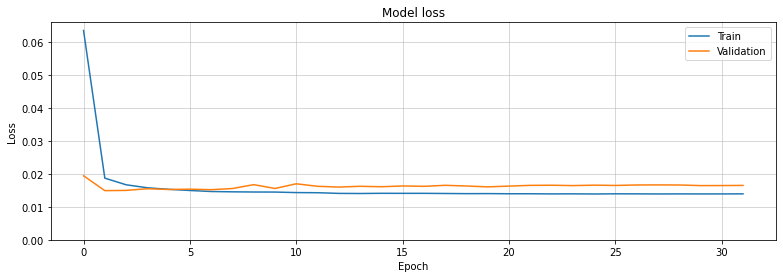

In [20]:
plot_loss(history)

In [ ]:
y_pred = model.predict(X_val, batch_size=1)
y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1], 1)

In [ ]:
plot(X_val, y_pred, y_val)

### Plot function

In [ ]:
def plot(x_hist, y_pred, y_true, max_subplots=3):
        plot_col = 'Wind Speed'
    
        
        plt.figure(figsize=(12, 8))
        plot_col_index = window.column_indices[plot_col]
        max_n = min(max_subplots, len(y_true))
        for n in range(max_n):
            i = np.random.randint(0,len(y_true))
            plt.subplot(max_n, 1, n+1)
            plt.ylabel('Wind Speed (m/s)')            
            
            # Historical inputs
            plt.plot(window.input_indices, x_hist[i, :],
                     label='Inputs', marker='.', zorder=-10)
            
            
#             # Forecast input
#             if window.forecast_columns:
#                 forecast_col_index = window.forecast_columns_indices.get('M50 [m/s]', None)
#             else:
#                 forecast_col_index = plot_col_index
            
#             ax2.plot(window.forecast_indices, x_fc[i, :, forecast_col_index],
#                      label='Forecast Inputs', marker='o', c='blue', zorder=-10)
            
            
            # Target
            if window.label_columns:
                label_col_index = window.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                label_col_index = 0
            
            # Label
            plt.plot(window.label_indices, y_true[i, :],
                        label='Labels', c='#2ca02c', marker='.')

            # Prediction
            plt.plot(window.label_indices, y_pred[i, :],
                        marker='X', label='Predictions', c='#ff7f0e')
            
            if n == 0:
                plt.legend()

            plt.xlabel('Time [h]')
            plt.tight_layout()

# Load Latest Model

In [13]:
model = tf.keras.models.load_model('./checkpoint/LSTM_WindSpeed_WindSpeed_model_lemon-sponge-49.h5')

In [40]:
ws_train = model.predict(X_train, batch_size=32)
ws_val   = model.predict(X_val, batch_size=32)
ws_test  = model.predict(X_test, batch_size=32)

In [41]:
ws_train = ws_train.reshape(ws_train.shape[0]*ws_train.shape[1])
ws_val = ws_val.reshape(ws_val.shape[0]*ws_val.shape[1])
ws_test = ws_test.reshape(ws_test.shape[0]*ws_test.shape[1])

In [42]:
np.save('./projectwind/data/WindSpeed_adapted_train.npy', np.asanyarray(ws_train, dtype=float))
np.save('./projectwind/data/WindSpeed_adapted_val.npy', np.asanyarray(ws_val, dtype=float))
np.save('./projectwind/data/WindSpeed_adapted_test.npy', np.asanyarray(ws_test, dtype=float))

In [43]:
ws_train = np.load('./projectwind/data/WindSpeed_adapted_train.npy', allow_pickle=True)
ws_val = np.load('./projectwind/data/WindSpeed_adapted_val.npy', allow_pickle=True)
ws_test = np.load('./projectwind/data/WindSpeed_adapted_test.npy', allow_pickle=True)

In [45]:
ws_train.shape

(369300,)

In [ ]:
ws_data = ws_data.reshape(ws_data.shape[0], ws_data.shape[1])

In [ ]:
data= pd.DataFrame(ws_data)

In [ ]:
data.head()